# Automatic Detection of ICMEs

This notebook documents the code used for the automatic detection of ICMEs. It is running on Python 3.8.5 with dependencies listed in the requirements.txt file.

In [1]:
#only use if GPU available

#Set devices_id
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-25 11:12:25.675361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 11:12:26.712541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 6.0


True

In [2]:
# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pds
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope

from unetgen import UnetGen
from m_resunet import ResUnetPlusPlus
from metrics import dice_coef, dice_loss, true_skill_score
import pickle
from loss_functions import *
import features
import preProcess

import pyarrow.parquet as pq
import event as evt


In [3]:
# Load data and event list

data = pq.read_table('datasetWithSpectro.parquet').to_pandas()

evtList = evt.read_csv('listOfICMEs.csv', index_col=None)

In [4]:
#preprocess on the data set
features.computeBeta(data)
features.computePdyn(data)
features.computeRmsBob(data)


startTime = datetime.datetime(1997,10,1)
endTime = datetime.datetime(2016,1,1)
data = data[data.index<endTime]
data = data[data.index>startTime]
data = data.resample('10T').mean().dropna()


# delete empty events

evtList = preProcess.clearempties(evtList, data)

Nieves-Chinchilla    313
Nguyen               640
Chi                  427
HELIO4CAST           144
dtype: object
     Nieves-Chinchilla Nguyen Chi HELIO4CAST
1998                29     52  34        NaN
1999                18     37  29        NaN
2000                31     56  43        NaN
2001                24     68  49        NaN
2002                21     46  31        NaN
2003                10     28  13        NaN
2004                13     27  16        NaN
2005                16     39  28        NaN
2006                13     17  10        NaN
2007                 7     11   5          7
2008                 5      9   6          5
2009                15     20  12         15
2010                14     37  16         15
2011                19     38  22         22
2012                29     48  37         30
2013                21     37  21         21
2014                15     33  23         15
2015                13     37  32         14


<Figure size 432x288 with 0 Axes>

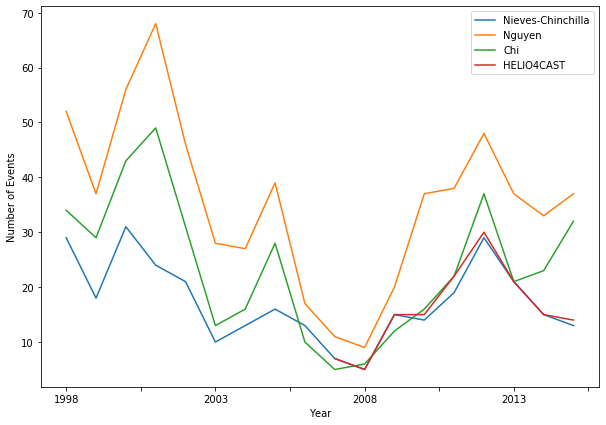

In [5]:
import postProcess
nguyen = evt.read_csv('listOfICMEs.csv', index_col=None)
chinchilla = evt.read_chinchilla()
chi = evt.read_chi()
helcats = evt.get_catevents()

dicoflists = {'Nieves-Chinchilla': chinchilla, 'Nguyen':nguyen, 'Chi':chi,'HELIO4CAST':helcats}
postProcess.compare_lists(dicoflists)

In [6]:
truelabel = pds.DataFrame(preProcess.get_truelabel(data, evtList))

In [7]:
scale = StandardScaler()
scale.fit(data)

data_scaled = pds.DataFrame(index = data.index, columns = data.columns, data = scale.transform(data))

In [8]:
# run for all 6 available splits to achieve overall result

split = 1
test, val, train = preProcess.getbalancedsplit(split, 'nguyen') 

In [9]:
X_test, Y_test, X_val, Y_val, X_train, Y_train = preProcess.getdatas(train,test,val,data_scaled,truelabel)

print(preProcess.printpercentage(Y_test))
print(preProcess.printpercentage(Y_train))
print(preProcess.printpercentage(Y_val))

label    0.102693
dtype: float64
label    0.104657
dtype: float64
label    0.10432
dtype: float64


In [10]:
s = Semantic_loss_functions()

file_path = "Results/"
model_path = "Results/resunetplusplus_split"+str(split)

## Parameters
C = 33
t = 1024
image_size = (t,1,C)
batch_size = 32
initial_learning_rate = 0.01
epochs =500

## Generator
train_gen = UnetGen(X_train, Y_train, length=int(t), stride = 120,  batch_size=batch_size,expanddims = True)
valid_gen = UnetGen(X_val, Y_val, length=int(t), stride = 120, batch_size=batch_size,expanddims = True)

semantic loss functions initialized


In [11]:
from cycliclr import *

expclr = CyclicLR(base_lr=0.00001, max_lr=0.01, step_size=1000)

In [12]:
## ResUnet++
arch = ResUnetPlusPlus(input_shape=image_size)
model = arch.build_medium()

optimizer = Adam() 

metrics = [Recall(), Precision(), dice_coef,true_skill_score, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics) 

csv_logger = CSVLogger(f"{file_path}unet_{batch_size}.csv", append=False)
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
callbacks = [csv_logger, checkpoint, early_stopping, expclr]


2022-07-25 11:12:46.619727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 6.0


In [13]:
model.summary()

Model: "ResUNetPlusPlusmedium"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1, 33) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1, 64)  6400        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1024, 1, 64)  256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1024, 1, 64)  0           batch_normalization[0][0]        
______________________________________________________________________________

In [14]:
model.fit(train_gen,
          validation_data=valid_gen,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/500


2022-07-25 11:12:47.813721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-25 11:12:52.722997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


158/158 [==============================] - 86s 480ms/step - loss: 0.5583 - recall: 0.5810 - precision: 0.3824 - dice_coef: 0.4397 - true_skill_score: 0.5581 - mean_io_u: 0.6044 - val_loss: 0.5460 - val_recall: 0.8930 - val_precision: 0.3561 - val_dice_coef: 0.4550 - val_true_skill_score: 0.7093 - val_mean_io_u: 0.5910

Epoch 00001: val_loss improved from inf to 0.54604, saving model to Results/resunetplusplus_split1


2022-07-25 11:14:19.381434: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Results/resunetplusplus_split1/assets
Epoch 2/500
158/158 [==============================] - 80s 508ms/step - loss: 0.5065 - recall: 0.5581 - precision: 0.4798 - dice_coef: 0.4932 - true_skill_score: 0.6028 - mean_io_u: 0.6188 - val_loss: 0.4679 - val_recall: 0.5774 - val_precision: 0.6703 - val_dice_coef: 0.5309 - val_true_skill_score: 0.5620 - val_mean_io_u: 0.6783

Epoch 00002: val_loss improved from 0.54604 to 0.46786, saving model to Results/resunetplusplus_split1
INFO:tensorflow:Assets written to: Results/resunetplusplus_split1/assets
Epoch 3/500
 71/158 [============>.................] - ETA: 47s - loss: 0.4848 - recall: 0.5427 - precision: 0.5558 - dice_coef: 0.5152 - true_skill_score: 0.6302 - mean_io_u: 0.6401

KeyboardInterrupt: 

In [ ]:
import postProcess
from glob import glob

batch_size = 1


## Model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef, 'true_skill_score': true_skill_score}): 
    model = load_model(model_path)
    

test_gen = UnetGen(X_test, Y_test, length=int(t), stride = int(t),batch_size=batch_size,expanddims = True)

model.evaluate(test_gen, verbose=1)

result = postProcess.generate_result(X_test, Y_test, model,C,t)

In [ ]:
nguyen = evt.read_csv('listOfICMEs.csv', index_col=None)
chinchilla = evt.read_chinchilla()
chi = evt.read_chi()
helcats = evt.get_catevents()

In [ ]:
result.index = pds.to_datetime(result.index)
resultbin = postProcess.make_binary(result['pred'], 0.5)
events = postProcess.makeEventList(resultbin, 1, 10)
ICMEs = postProcess.removeCreepy(events, 3)
test_clouds = [x for x in nguyen if ((x.begin.year== test[0]) or (x.begin.year == test[1]) or (x.begin.year==test[2]))]

In [ ]:
import performance as prf

TP, FN, FP, detected = prf.evaluate(ICMEs, test_clouds, thres=0.1)
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

delay = np.zeros(len(TP))

for j in range(0, len(detected)):
        delay[j] = ((TP[j].begin - detected[j].begin).total_seconds())/(TP[j].duration).total_seconds()

print('Mean Delay', (np.sum(delay) / len(delay))*100)

In [ ]:
startlag = []
endlag = []

for i in range(0, len(detected)):
    predstart = TP[i].begin
    predend = TP[i].end
    startlag.append((predstart-detected[i].begin).total_seconds()/60)
    endlag.append((predend-detected[i].end).total_seconds()/60)

In [ ]:
import pickle

with open('Results/startlag'+str(split)+'.p', 'wb') as fp:
    pickle.dump(startlag, fp)
    
with open('Results/endlag'+str(split)+'.p', 'wb') as fp:
    pickle.dump(endlag, fp)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from cm import make_confusion_matrix

cm = confusion_matrix(result['true'], resultbin)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Background', 'ICME']

In [ ]:
np.savetxt('Results/cm'+str(split)+'.txt',cm)
cmevent = np.array([[0,len(FP)],[len(FN),len(TP)]])
np.savetxt('Results/cmevent'+str(split)+'.txt',cmevent)

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Background', 'ICME']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')